## Probabilidad y Estadística CEIA Coh17.
## Trabajo Práctico Nº2.

### Autores: Joaquín Matías Mestanza, Gonzalo Nicolas Silva Caggiano, Ramiro Andrés Feichubuinm
### Grupo 4

## Punto 1 - Cuadrados Mínimos

In [1]:
# Cargamos los datos en una matriz
import numpy as np 
# A w  = b
x = np.array([0, 5, 10, 15, 24], dtype=np.float64)
_1 = np.ones(len(x), dtype =np.float64)
A = np.array([_1, x, x**2]).T
print(A)
print(A.shape)

[[  1.   0.   0.]
 [  1.   5.  25.]
 [  1.  10. 100.]
 [  1.  15. 225.]
 [  1.  24. 576.]]
(5, 3)


In [2]:
y = np.array([10, 18, 151, 219, 492], dtype=np.float64)

Basandonos en las ecuaciones de LeastSquareFittingPolynomial:
https://mathworld.wolfram.com/LeastSquaresFittingPolynomial.html

$$
A w = y 
$$
$$
A^{t}A w = A^{t} \cdot y
$$
$$
w = (A^{t}A)^{-1} A^{t} \cdot y
$$

In [3]:
A_dagger = np.linalg.inv(A.T@A)@A.T
w = A_dagger@y
print('Los coeficientes son:')
# print(w)
for coef, el in zip(['a','b','c'], w):
    print(f'{coef}: {el:.4f}')

Los coeficientes son:
a: 0.3183
b: 6.3429
c: 0.5895


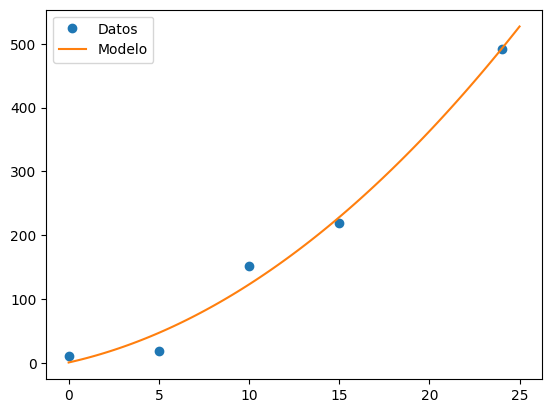

In [4]:
from matplotlib import pyplot as plt
plt.plot(x,y, 'o', label='Datos')
t = np.linspace(0, 25,100)
plt.plot(t, w[0]*1 + w[1]*t + w[2]*(t**2), label='Modelo')
plt.legend()

## Punto 2 - Primera parte
### Almacenamiento de los datos


In [5]:
import pandas as pd
sales = pd.read_excel('Datos_segundo_punto_17Co2024_Grupo4.xlsx')
sales["Mes"] = sales["Fecha"].dt.month # alternativa: dt.month_name()
sales["DiaDeSemana"] = sales["Fecha"].dt.weekday
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Fecha        365 non-null    datetime64[ns]
 1   Ventas       365 non-null    float64       
 2   Mes          365 non-null    int32         
 3   DiaDeSemana  365 non-null    int32         
dtypes: datetime64[ns](1), float64(1), int32(2)
memory usage: 8.7 KB


In [6]:
sales.head()

,Fecha,Ventas,Mes,DiaDeSemana
0,2023-01-01,14864.134184,1,6
1,2023-01-02,16853.696596,1,0
2,2023-01-03,20726.932468,1,1
3,2023-01-04,19102.646430,1,2
4,2023-01-05,18955.206970,1,3


In [7]:
sales.tail()

,Fecha,Ventas,Mes,DiaDeSemana
360,2023-12-27,24173.447572,12,2
361,2023-12-28,22654.251064,12,3
362,2023-12-29,22822.365415,12,4
363,2023-12-30,19059.956125,12,5
364,2023-12-31,17446.387915,12,6


## a) ¿Cómo se comportan las ventas mes a mes?

In [8]:
import matplotlib.pyplot as plt
import math
def plot_sales(data, plot_fun,title, n = 3, pad = 2.0, fig_size = (10,10)):
    m = math.ceil(len(data)/n)
    figure, axis = plt.subplots(m,n, figsize=fig_size)
    figure.tight_layout(pad = pad)
    for i in range(m*n):
        row = i//n
        col = i%n
        if i < len(data):
            axis[row][col].set_title(f"{title}: {i+1}")
            plot_fun(data[i], axis[row][col])
        else: 
            axis[row][col].axis('off')

In [9]:
sales_per_month = [sales[sales["Mes"] == (i+1)]["Ventas"].values for i in range(12)]

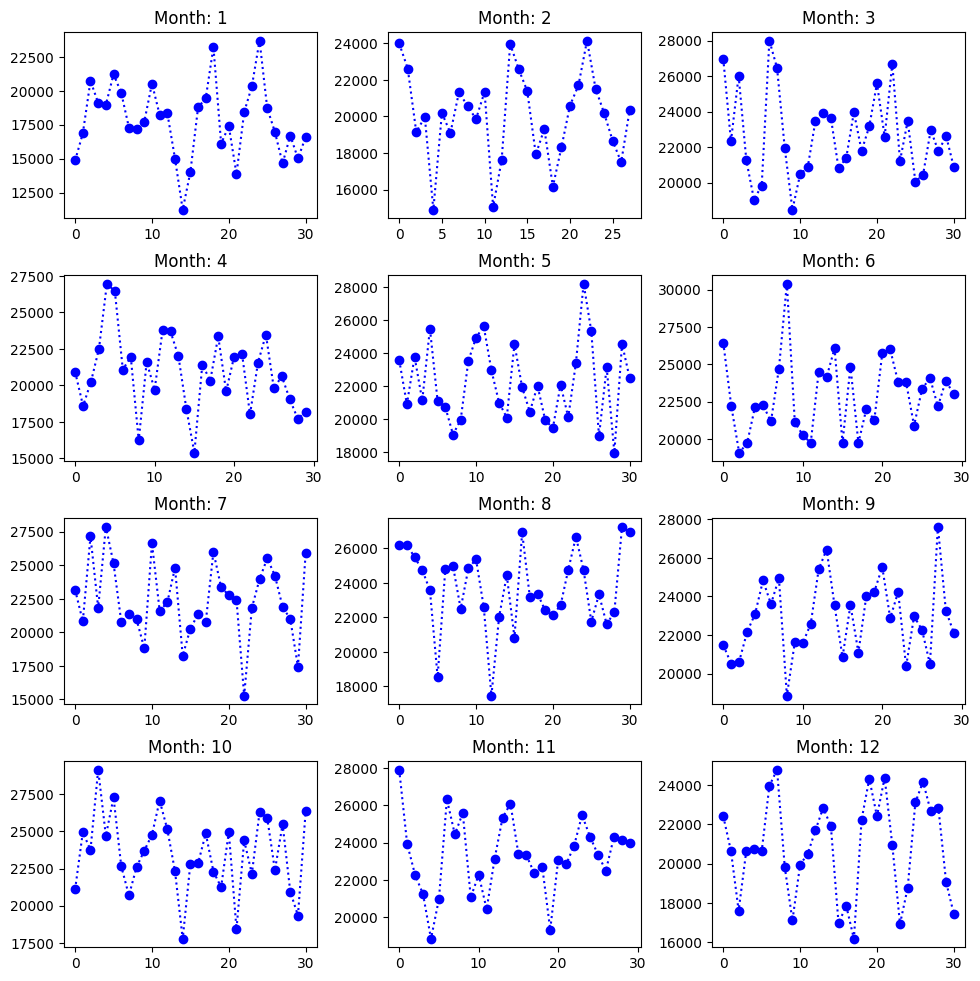

In [10]:
def month_sale_plot_fun(data, ax):    
    ax.plot(range(len(data)), data, color='blue', linestyle=':', marker='o')
plot_sales(sales_per_month,  month_sale_plot_fun , title='Month')

## b) ¿Cómo se comportan las ventas en cada día de la semana?

In [11]:
sales_per_weekday = [sales[sales["DiaDeSemana"] == i]["Ventas"].values for i in range(7)]

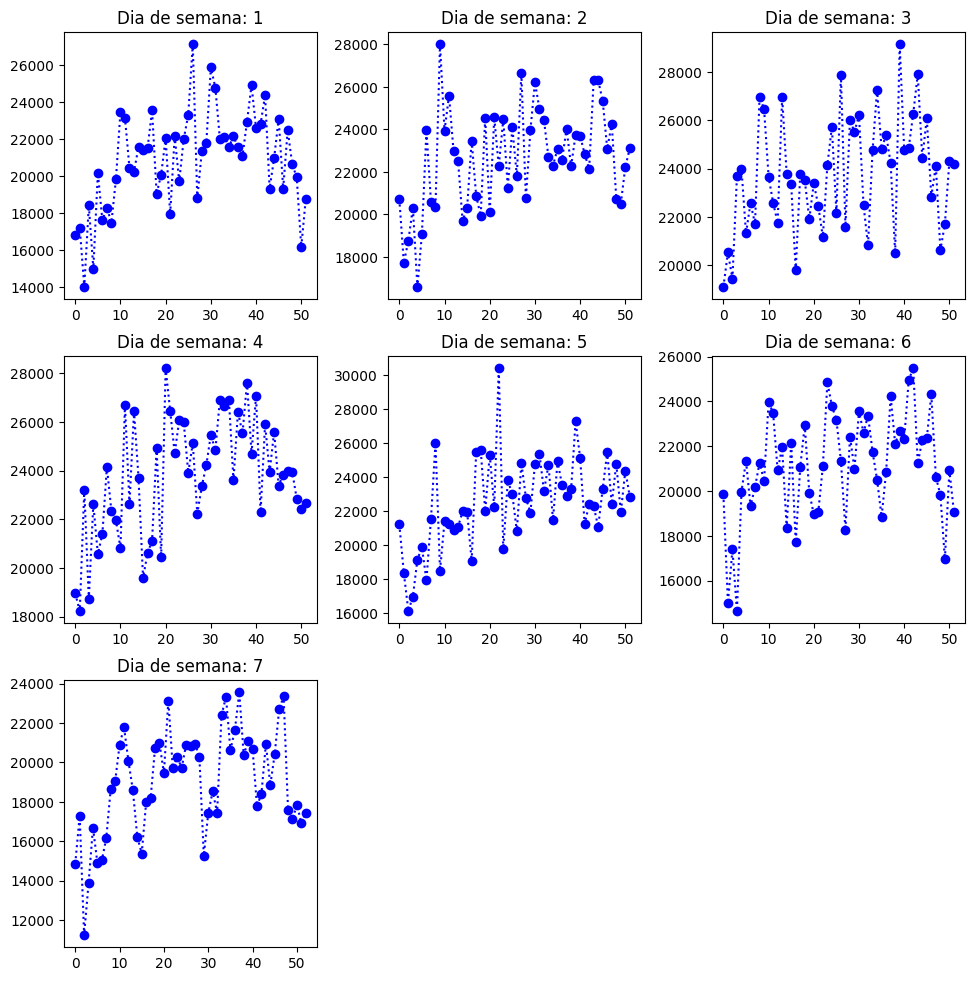

In [12]:
def weekday_sale_plot_fun(data, ax):    
    ax.plot(range(len(data)), data, color='blue', linestyle=':', marker='o')        

plot_sales(sales_per_weekday,  weekday_sale_plot_fun , title='Dia de semana')

Donde dia 0 corresponde a Lunes, y 6 a Domingo.

## Punto 2 - Segunda Parte

Para poder elegir distintos Kernels se utilizó la función GridSearchCV que lo que hace es una búsqueda de tipo fuerza bruta en la que prueba todas las combinaciones dado un set de parámetros.
En este caso disponíamos de distintos Kernels que nos provee la librería Scikit Learn: 
```python
['gaussian', 'epanechnikov', 'exponential', 'linear', 'cosine', 'tophat']
```
Y para el bandwidth se realizó un barrido lineal partiendo de 0.1 a 10000 teniendo 1000 muestras: 

```python
np.linspace(start=0.1, stop=10000, num=1000)
# nos da un output del estilo:
Out[5]: array([ 0.1       , 10.10990991, 20.11981982, 30.12972973, 40.13963964, ...])
```



Como criterio de selección de kernel se optó por el que maximice el likelihood. 

In [13]:
# --- Turning off warnings for grid search
import warnings
warnings.filterwarnings("ignore")
# ----

import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

def plot_estimations(X, ax):
    # assume X is 1-Dimensional, X is the data array
    ecdf = ECDF(X)    
    
    # Validación cruzada para identificar kernel y bandwidth
    # ==============================================================================
    
    param_grid = {
        'kernel': ['gaussian', 'epanechnikov', 'exponential', 'linear', 'cosine', 'tophat'],
        'bandwidth' : np.linspace(start=0.1, stop=10000, num=1000)
    }
    
    grid = GridSearchCV(
            estimator  = KernelDensity(),
            param_grid = param_grid,
            n_jobs     = -1,
            cv         = 10, 
            verbose    = 0
          )
    
    # Se asigna el resultado a _ para que no se imprima por pantalla
    _ = grid.fit(X = X.reshape(-1,1))
    # .reshape(-1.1) => [[x1], [x2], ...] 
    
    
    # Mejores hiperparámetros por validación cruzada
    # ==============================================================================
    # print("----------------------------------------")
    # print("Mejores hiperparámetros encontrados (cv)")
    # print("----------------------------------------")
    # print(grid.best_params_, ":", grid.best_score_, grid.scoring)
    
    modelo_kde_final = grid.best_estimator_
    
    
    # Gráficos distribución de densidad modelo final
    # ==============================================================================
    X_grid = np.linspace(start=min(X), stop=max(X), num=100)
    log_density_pred = modelo_kde_final.score_samples(X_grid.reshape(-1,1))
    density_pred = np.exp(log_density_pred)

    density, bins, patches = ax.hist(X, bins=100, density=True)
    
    bw = grid.best_params_["bandwidth"]
    bw_plot = [bw if type(bw) == str else "{0:.3f}".format(bw)] 
    
    ax.plot(X_grid, density_pred, color = 'red', label=f'Kernel: {grid.best_params_["kernel"]} \n bw: {bw_plot}')
    ax.plot(X.flatten(), np.full_like(X.flatten(), -0.00001), '|k', markeredgewidth=1)
    ax.set_xlabel('x')
    ax.set_ylabel('densidad')
    ax.legend(loc='upper left')
    ax2 = ax.twinx()
    ax2.plot(ecdf.x, ecdf.y, marker='o', linestyle=':', color='orange', label='ECDF')
    ax2.legend(loc=4)

## a)  Funciones empı́ricas de distribución y aproximaciones a las funciones de densidad para dichas distribuciones, para las ventas durante cada uno de los meses del año.

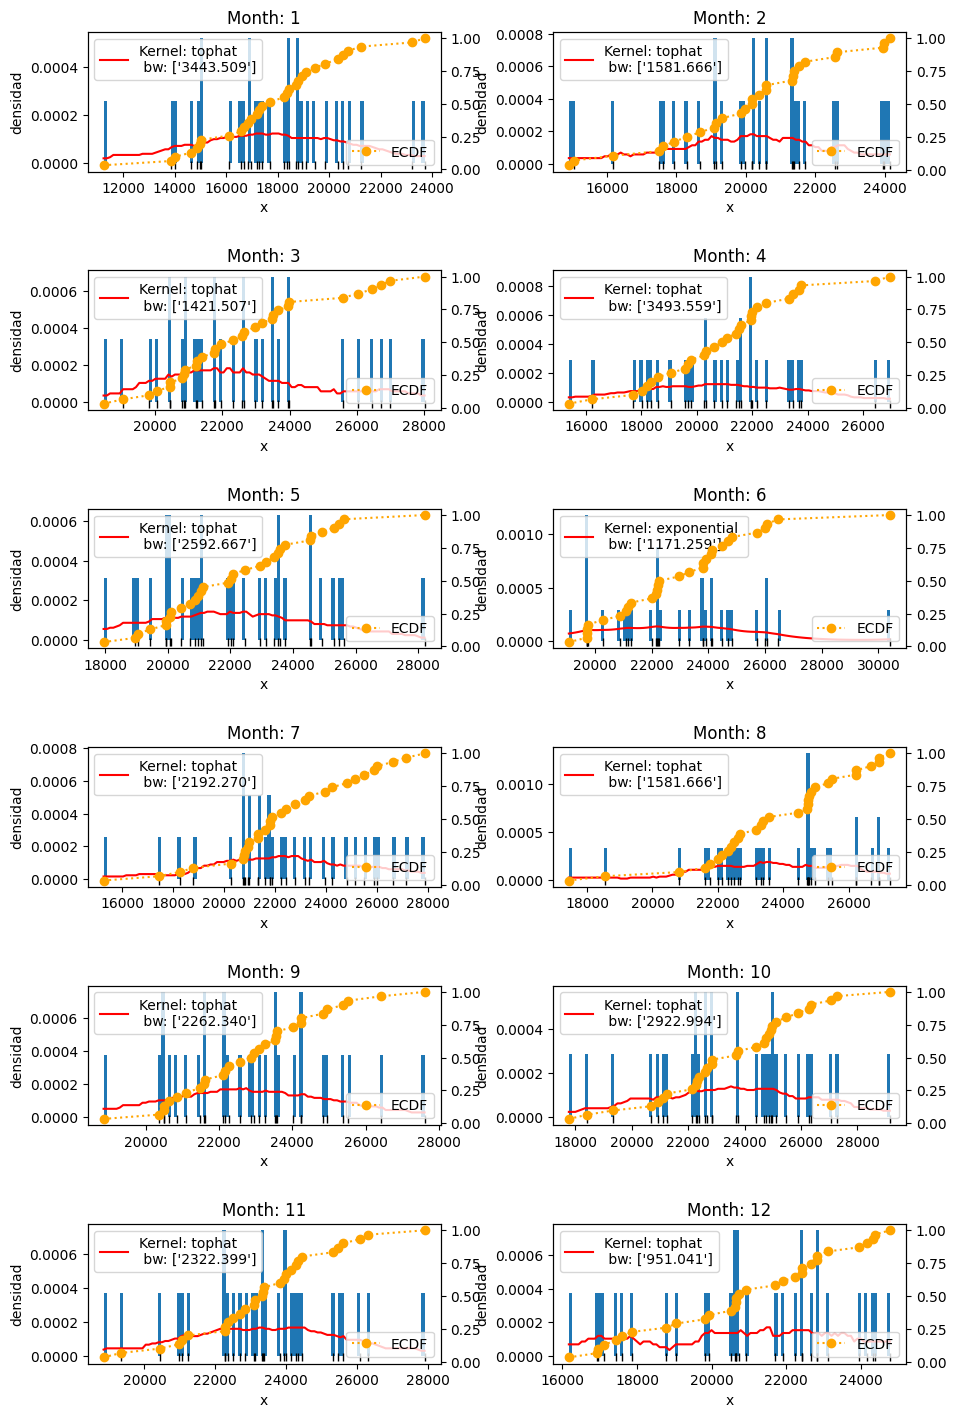

In [14]:
def month_estimation_plot_fun(data, ax):    
    plot_estimations(data, ax)
plot_sales(sales_per_month, month_estimation_plot_fun, title='Month', n=2, pad=5, fig_size=(10,15))

## b) Funciones empı́ricas de distribución y aproximaciones a las funciones de densidad para dichas distribuciones, para las ventas por cada dı́a de la semana.

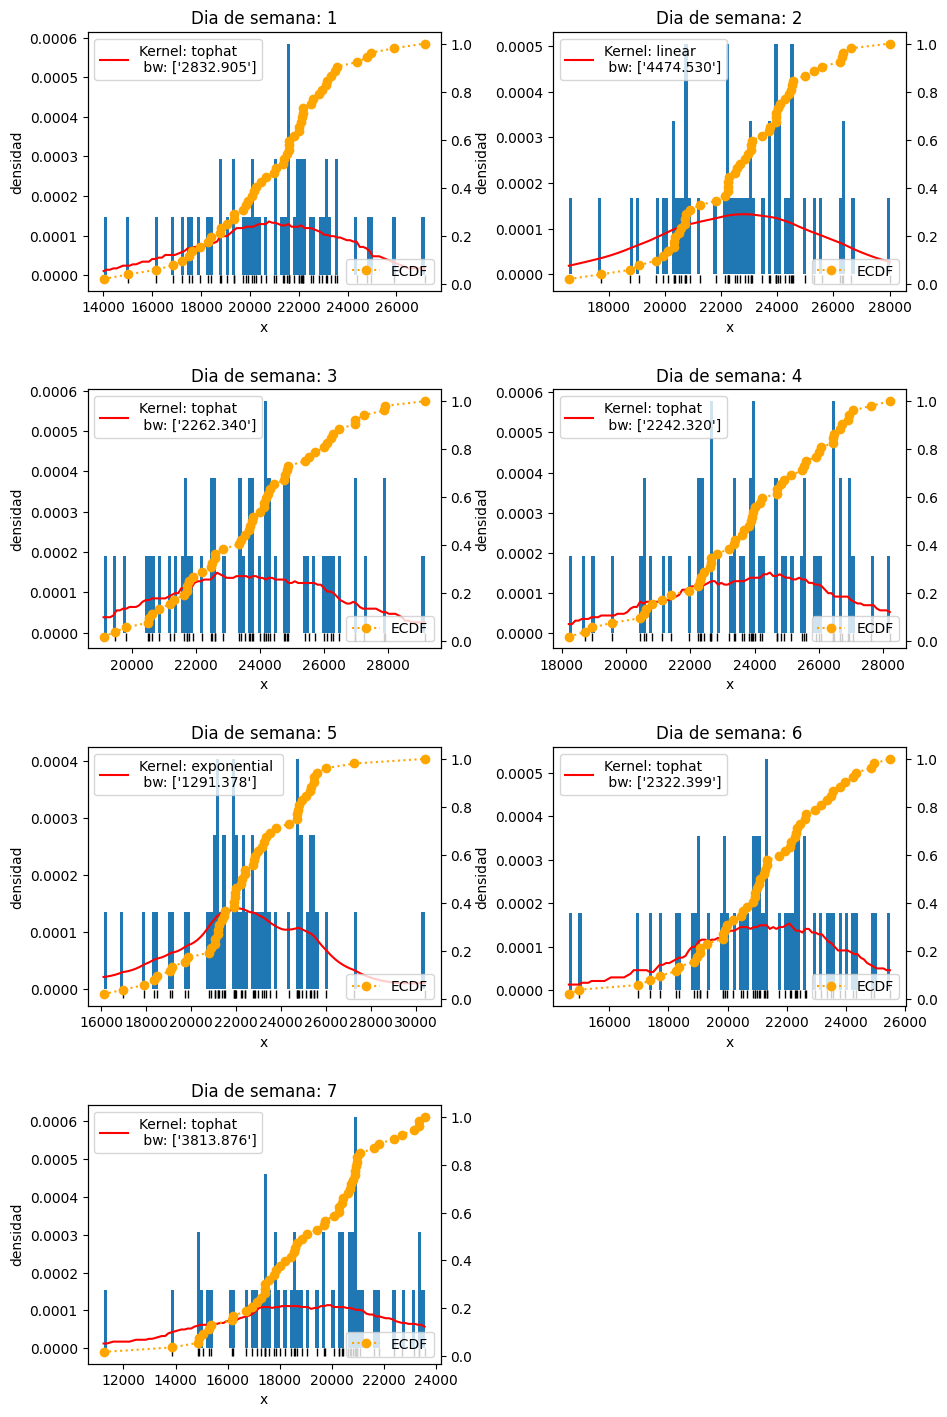

In [16]:
def weekday_estimation_plot_fun(data, ax):    
    plot_estimations(data, ax)
plot_sales(sales_per_weekday,  weekday_estimation_plot_fun , title='Dia de semana', n=2, pad=5, fig_size=(10,15))